# Things to look in to
* What parameter values determine whether steady state will be reached?
* Adapting model to account for social bias
* Rank empty equares on basis of how good they are
* Model currently looks at how mcuh people want to be around similar people - what if model account for how mcuh people want to be away from different people?


In [1]:
import matplotlib.pyplot as plt
import itertools
import random
import copy
import itertools
import numpy as np
from collections import defaultdict
from more_itertools import locate
from scipy.stats import ttest_ind

In [1]:
class Schelling:
    
    def __init__(self, width, height, empty_ratio, similarity_threshold, n_iterations, races, races_ratios, social_bias, show = False):
        self.width = width
        self.height = height
        self.empty_ratio = empty_ratio
        self.similarity_threshold = similarity_threshold
        self.n_iterations = n_iterations
        self.races = races
        self.races_ratios = races_ratios
        self.cols = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
        self.social_bias = social_bias
        self.show = show
        
    def populate(self):
        self.empty_houses = []
        self.agents = {}
        self.all_houses = list(itertools.product(range(self.width), range(self.height)))
        random.shuffle(self.all_houses)
        self.n_empty = int(self.empty_ratio * len(self.all_houses))
        self.empty_houses = self.all_houses[:self.n_empty]
        self.remaining_houses = self.all_houses[self.n_empty:]
        houses_by_races = []
        self.races_num = [round(i*len(self.remaining_houses)) for i in self.races_ratios]
        #print(self.races_num)
        races_no = list(np.cumsum(self.races_num))
        races_no.append(0)
        for i in range(self.races):
            houses_by_races.append(self.remaining_houses[races_no[i-1]:races_no[i]])
            race = [i]*len(houses_by_races[i])
            self.agents.update(zip(houses_by_races[i], race))
            
    def plot_city(self):
        fig, ax = plt.subplots(figsize=(self.width*0.5, self.height*0.5))
        ax.set_xlim([-1, self.width-1])
        ax.set_ylim([-1, self.height-1])
        ax.set_xticks(np.arange(0, self.width, 1))
        ax.set_yticks(np.arange(0, self.height, 1))
        ax.xaxis.set_ticklabels([])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticklabels([])
        ax.yaxis.set_ticks_position('none')
        ax.grid()           
        for key, value in self.agents.items():           
            x = key[0]-0.5
            y = key[1]-0.5
            ax.scatter(x, y, c=self.cols[value], marker='s', s=500)
        
    def is_unsatisfied(self, location):
        race = self.agents[location]
        locs = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 2], [2, 0], [2, 1], [2, 2]]
        same_race = 0
        diff_race = 0
        x = location[0]-1
        y = location[1]-1
        for i in locs:
            nbor = []
            nbor.append(i[0] + x)
            nbor.append(i[1] + y)
            nbor_tup = tuple(nbor)
            if nbor_tup in self.agents:
                if self.agents[nbor_tup] == race:
                    same_race += 1
                else:
                    diff_race += 1
        if same_race == diff_race == 0:
            return False # Assumes that households are fine being alone
        elif same_race/(same_race + diff_race) < self.similarity_threshold:
            return True
        else:
            return False  
    
    def update(self):
        sim_indices = []
        sim_indices_race = []
        sim_indices.append(self.similarity())
        sim_indices_race.append(self.sim_by_race())
        for j in range(self.n_iterations):
            options = self.empty_ranks()
            rand_keys = random.sample(list(self.agents.keys()), len(self.agents))
            newdict = {}
            for w in rand_keys:
                newdict[w] = self.agents[w]
            self.agents = newdict    
            res = defaultdict(list)
            for key, val in sorted(self.agents.items()):
                res[val].append(key)                
            ranking = sorted(self.social_bias)
            for n in np.unique(ranking):
                rand_rank = list(locate(self.social_bias, lambda x: x == n))
                random.shuffle(rand_rank)
                for p in rand_rank:
                    sorted_new = dict(sorted(options[p].items(), key=lambda item: item[1], reverse=True))
                    for i in res[p]:
                        if self.is_unsatisfied(i) == True:
                            #new = random.choice(self.empty_houses)
                            new = list(sorted_new.keys())[0]
                            self.agents[new] = self.agents[i]
                            self.empty_houses.append(i)
                            self.empty_houses.remove(new)
                            del self.agents[i]
                            del sorted_new[new]
                            sorted_new[i] = 0 # Assumes 0 similairty ratio for new houses on market
                            for q in range(len(options)):
                                del options[q][new]
                                options[q][i] = 0 # Assumes 0 similairty ratio for new houses on market
            sim_indices.append(self.similarity())
            sim_indices_race.append(self.sim_by_race())
            if self.show == True and (j==0 or j==self.n_iterations-1):
                self.plot_city()
                print(self.similarity())
        if self.show == True:
            self.sim_graph(sim_indices)
            self.sim_graph_races(sim_indices_race)
        return(sim_indices[-1], sim_indices_race[-1])
    
    def similarity(self):
        sim_index = 0
        for i in self.agents:
            race = self.agents[i]
            locs = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 2], [2, 0], [2, 1], [2, 2]]
            same_race = 0
            diff_race = 0
            x = i[0]-1
            y = i[1]-1
            for n in locs:
                nbor = []
                nbor.append(n[0] + x)
                nbor.append(n[1] + y)
                nbor_tup = tuple(nbor)
                if nbor_tup in self.agents:
                    if self.agents[nbor_tup] == race:
                        same_race += 1
                    else:
                        diff_race += 1
            if same_race == diff_race == 0:
                sim_index += 0
            else:
                sim_index += (same_race/(same_race + diff_race))
        return sim_index/len(self.agents)  
    
    def sim_graph(self, sim_indices):
        fig, ax = plt.subplots(figsize=(self.width*0.5, self.height*0.5))
        for i in range(len(sim_indices)):
            ax.scatter(i, sim_indices[i])
        ax.plot(range(len(sim_indices)), sim_indices)
    
    def sim_graph_races(self, sim_by_race):
        fig = plt.figure(figsize=(self.width*0.5, self.height*0.5))
        for j in range(self.races):
            y = []
            for i in (sim_by_race):
                y.append(i[j])
            plt.plot(range(len(y)), y, color=self.cols[j])
    
    def sim_by_race(self):
        sim_index = [0]*self.races
        for i in self.agents:
            race = self.agents[i]
            locs = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 2], [2, 0], [2, 1], [2, 2]]
            same_race = 0
            diff_race = 0
            x = i[0]-1
            y = i[1]-1
            for n in locs:
                nbor = []
                nbor.append(n[0] + x)
                nbor.append(n[1] + y)
                nbor_tup = tuple(nbor)
                if nbor_tup in self.agents:
                    if self.agents[nbor_tup] == race:
                        same_race += 1
                    else:
                        diff_race += 1
            if same_race == diff_race == 0:
                sim_index[race] += 0
            else:
                sim_index[race] += (same_race/(same_race + diff_race))
        return [sim_index[i]/self.races_num[i] for i in range(self.races)]
    
    def empty_ranks(self):
        list_dics = []
        for j in range(self.races):
            list_dics.append({})
            for i in self.empty_houses:
                locs = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 2], [2, 0], [2, 1], [2, 2]]
                same_race = 0
                diff_race = 0
                x = i[0]-1
                y = i[1]-1
                for n in locs:
                    nbor = []
                    nbor.append(n[0] + x)
                    nbor.append(n[1] + y)
                    nbor_tup = tuple(nbor)
                    if nbor_tup in self.agents:
                        if self.agents[nbor_tup] == j:
                            same_race += 1
                        else:
                            diff_race += 1
                if same_race == diff_race == 0:
                    list_dics[j][i] = 0
                else:
                    (list_dics[j])[i] = (same_race/(same_race + diff_race))
        return list_dics

In [90]:
def run_chars(num, ratios, bias):
    diffs = []
    race_lists = []
    line_cols = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    fig = plt.figure()
    for i in range(len(ratios)):
        race_lists.append([])
    for i in range(num):
        races_ratios = ratios
        social_bias = bias
        test = Schelling(20, 20, 0.1, 0.33, 100, len(races_ratios), races_ratios, social_bias)
        test.populate()
        a, b = test.update()
        diffs.append(a)
        for i in range(len(b)):
            race_lists[i].append(b[i])
    #plt.plot(range(num), diffs)
    for i in range(len(race_lists)):
        plt.plot(range(num), race_lists[i], color=line_cols[i])
    for i in race_lists:
        print(sum(i)/len(i))
    print(sum(diffs)/len(diffs))
    return (race_lists, diffs)

0.7591463844797179
0.7600052910052911
0.7595758377425044


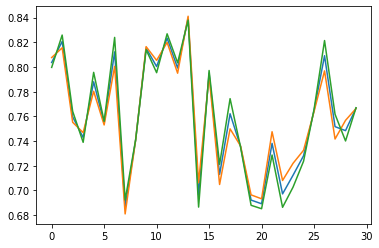

In [61]:
equal_soc_1 = run_chars(30, [0.5, 0.5], [1, 1])

0.7694791666666667
0.7652123015873016
0.4234964726631392
0.7325744604958085


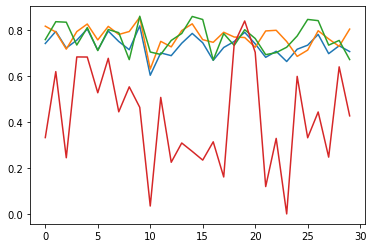

In [67]:
bias_soc_1 = run_chars(30, [0.45, 0.45, 0.1], [1, 1, 1])

0.737497023809524
0.7557420634920636
0.48910934744268075
0.720579186730872


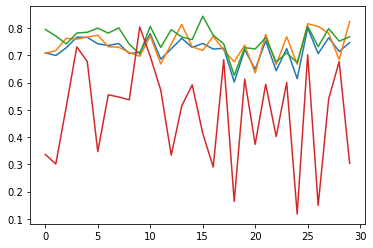

In [68]:
bias_soc_2 = run_chars(30, [0.45, 0.45, 0.1], [2, 2, 1])

0.7201362433862435
0.7371671075837744
0.7187557319223984
0.5025952380952379
0.7030772486772485


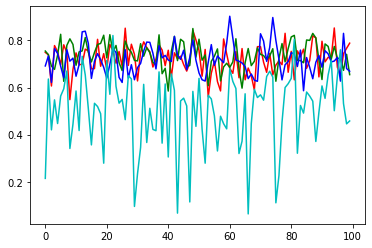

In [104]:
race_1, tot_1 = run_chars(100, [0.3, 0.3, 0.3, 0.1], [1, 1, 1, 1])

0.7376106701940034
0.7167601410934743
0.7269131393298057
0.4389074074074073
0.6982759259259259


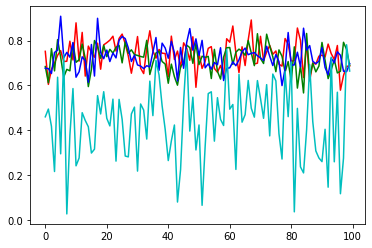

In [105]:
race_2, tot_2 = run_chars(100, [0.3, 0.3, 0.3, 0.1], [1, 1, 1, 2])

0.7236410934744267
0.7239215167548501
0.7298368606701938
0.58005291005291
0.7112251322751325


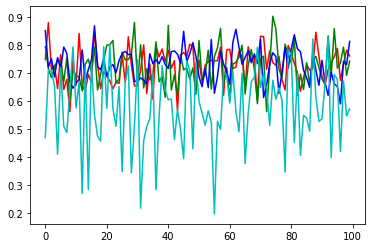

In [106]:
race_3, tot_3 = run_chars(100, [0.3, 0.3, 0.3, 0.1], [2, 2, 2, 1])

In [107]:
types = [race_1[3], race_2[3], race_3[3]]

for i in types:
    for j in types:
        t, p = ttest_ind(i, j, equal_var=False)
        print(types.index(i), " vs ", types.index(j), "\n", p)

0  vs  0 
 1.0
0  vs  1 
 0.006631054429129366
0  vs  2 
 0.00029863508952467446
1  vs  0 
 0.006631054429129366
1  vs  1 
 1.0
1  vs  2 
 1.0837334561246465e-09
2  vs  0 
 0.00029863508952467446
2  vs  1 
 1.0837334561246465e-09
2  vs  2 
 1.0


In [108]:
types = [tot_1, tot_2, tot_3]

for i in types:
    for j in types:
        t, p = ttest_ind(i, j, equal_var=False)
        print(types.index(i), " vs ", types.index(j), "\n", p)

0  vs  0 
 1.0
0  vs  1 
 0.4088050080948582
0  vs  2 
 0.15916508087696404
1  vs  0 
 0.4088050080948582
1  vs  1 
 1.0
1  vs  2 
 0.02336821793245892
2  vs  0 
 0.15916508087696404
2  vs  1 
 0.02336821793245892
2  vs  2 
 1.0


0.5297298740123852
0.6755898996369845


0.6755898996369845

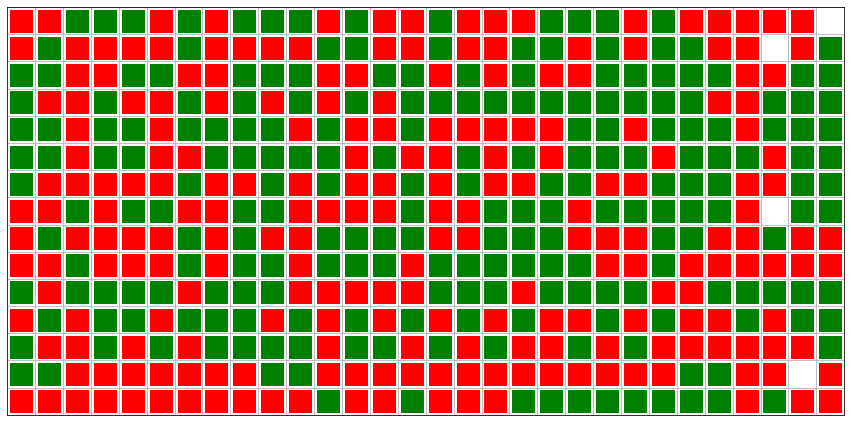

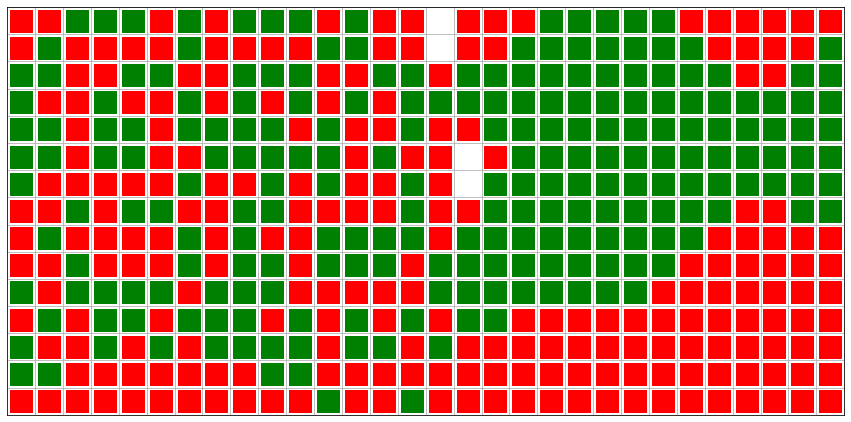

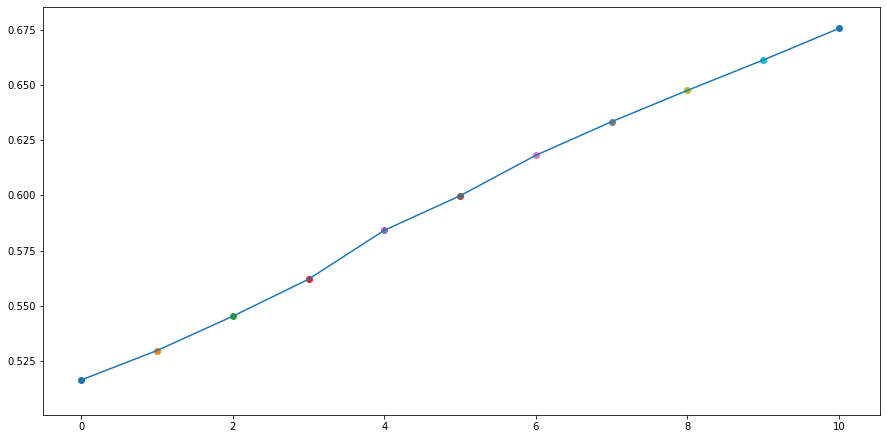

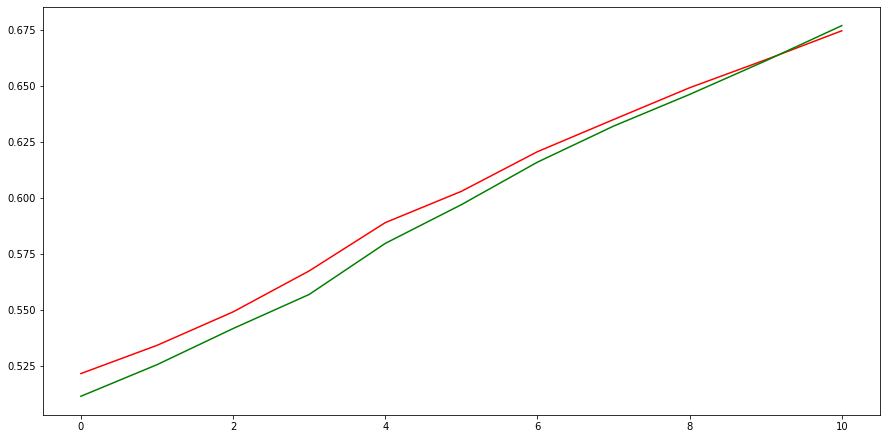

In [9]:
races_ratios = [0.5, 0.5]
social_bias = [1, 2]
test = Schelling(30, 15, 0.01, 0.4, 10, 2, races_ratios, social_bias, show=True)
test.populate()
test.update() 

In [10]:
races_ratios = [0.24, 0.24, 0.24, 0.24, 0.04]
social_bias = [1, 1, 1, 1, 2]
test = Schelling(30, 10, 0.1, 0.33, 250, 5, races_ratios, social_bias)
test.populate()
test.update() 

0.7221164021164019

In [11]:
abc = [{'A':1, 'B':7}, {'C':2, 'D':5}]
abc[0]['U'] = 9
print(abc)

[{'A': 1, 'B': 7, 'U': 9}, {'C': 2, 'D': 5}]


In [23]:
x = [[]]*4
print(x)

[[], [], [], []]
